## OVERVIEW
---
* Text Preprocessing
* XGBoost HyperParameter Tuning
* Data Pipeline
* Plotting ROC Curve
* Comparison of predictive models.

In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from string import punctuation
import nltk
from nltk.corpus import stopwords

#Preprocessing
from scipy.stats import uniform
from scipy import interp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


#predictive model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amazon-music-reviews/Musical_Instruments_5.json
/kaggle/input/amazon-music-reviews/Musical_instruments_reviews.csv


In [2]:
#get the data
df = pd.read_csv('../input/amazon-music-reviews/Musical_instruments_reviews.csv')

In [3]:
#show the dataframe
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## DATA BASIC INFORMATION
---

In [4]:
#show feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [5]:
#show decriptive stats of ratings
df.groupby('overall').describe()

unixReviewTime                                            \
                 count          mean           std           min   
overall                                                            
1.0              217.0  1.363610e+09  3.693997e+07  1.141344e+09   
2.0              250.0  1.361242e+09  3.770940e+07  1.190678e+09   
3.0              772.0  1.361718e+09  3.633831e+07  1.161389e+09   
4.0             2084.0  1.359799e+09  3.914760e+07  1.095466e+09   
5.0             6938.0  1.360608e+09  3.757515e+07  1.096416e+09   

                                                                 
                  25%           50%           75%           max  
overall                                                          
1.0      1.347926e+09  1.370995e+09  1.390349e+09  1.405210e+09  
2.0      1.342116e+09  1.369872e+09  1.389506e+09  1.405210e+09  
3.0      1.343282e+09  1.369008e+09  1.389053e+09  1.405901e+09  
4.0      1.342915e+09  1.369138e+09  1.388707e+09  1.405987e+09  
5.0      1.343606e+09  1.367971e+09  1.388945e+09  1.405901e+09

#### CHECK NULL VALUES

In [6]:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

### DATA DISTRIBUTION

Text(0.5, 0, 'Rating')

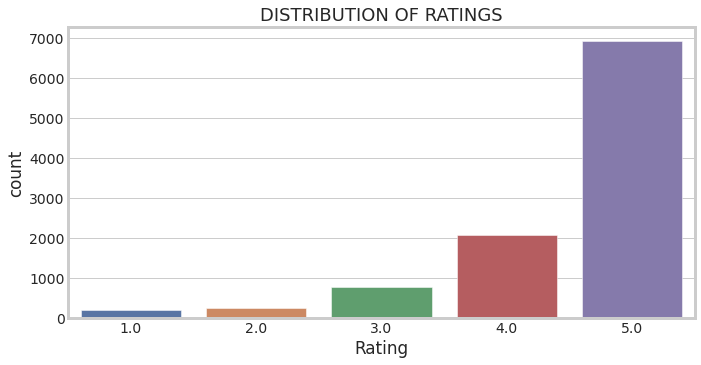

In [7]:
plt.figure(figsize=(10,5))
plt.title('DISTRIBUTION OF RATINGS', fontsize=18)
sns.countplot(df.overall, palette='deep')
plt.xlabel('Rating')

> ### DATA CLEANING & FEATURE SELECTION

In [8]:
#show columns
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [9]:
df.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)
#show new dataframe
df.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [10]:
#combining summary and reviewtext feature
df['review'] = df['reviewText'] + df['summary']
df.drop(['reviewText', 'summary'], axis=1, inplace=True)

In [11]:
#replace the ratings to sentiments

def num_to_sent(x):
    if (int(x) == 1 or int(x)==2 or int(x)==3):
        return 0
    else:
        return 1
df['overall'] = df.overall.apply(num_to_sent)

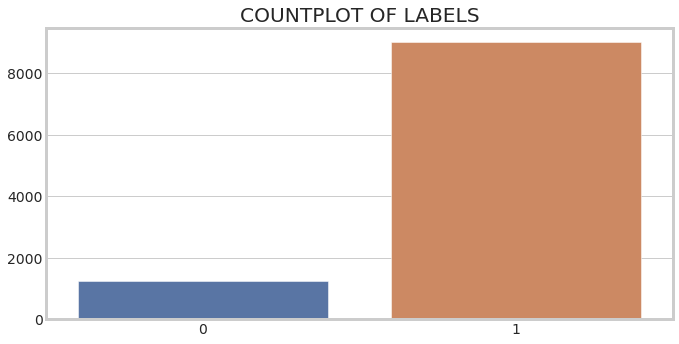

In [12]:
#show value counts
plt.figure(figsize=(10,5))
plt.title('COUNTPLOT OF LABELS')
sns.barplot(df.overall.value_counts().index,df.overall.value_counts().values, palette='deep')

## TEXT PREPROCESSING
---

In [13]:
#get the stopwords and punctuation
stop = stopwords.words('english')
punc = list(punctuation)

In [14]:
#remove stop words
text_clean = []
for i in range(len(df.review)):
    char_clean = []
    for char in str(df['review'][i]).split():
        char = char.lower()
        if char not in stop:
            char_clean.append(char)
        else:
            continue
    char_clean = ' '.join(char_clean)
    text_clean.append(char_clean)
df['review'] = text_clean

In [15]:
#remove punctuations
text_clean = []
for i in range(len(df.review)):
    char_clean = []
    for char in df['review'][i]:
        char = char.lower()
        if char not in punc:
            char_clean.append(char)
        else:
            continue
    char_clean = ''.join(char_clean)
    text_clean.append(char_clean)
df['review'] = text_clean

In [16]:
#show text sample
df.review[2]

'primary job device block breath would otherwise produce popping sound allowing voice pass noticeable reduction volume high frequencies double cloth filter blocks pops lets voice coloration metal clamp mount attaches mike stand secure enough keep attached goose neck needs little coaxing stay put itit job well'

## PREDICTIVE MODELLING
---

### XGB CLASSIFIER

In [17]:
#split the data
X = df.review
y = df.overall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#### HYPER PARAMETER TUNING

In [30]:

#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=3) #25 iterations

#### CREATE A DATA PIPELINE

In [22]:
model  = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', rs)
])

In [23]:
#fit the data
model.fit(X_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 RandomizedSearchCV(estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                                            max_delta_step=None,
                

In [24]:
#predict the test data
predictions=model.predict(X_test)

In [27]:
print('Model Accuracy: ', round(accuracy_score(y_test, predictions)*100,2), '%')

Model Accuracy:  88.7 %


#### CLASSIFICATION REPORT

In [28]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.23      0.34       252
           1       0.90      0.98      0.94      1801

    accuracy                           0.89      2053
   macro avg       0.75      0.61      0.64      2053
weighted avg       0.86      0.89      0.86      2053



### RANDOM FOREST WITH ROC CURVE

In [59]:
#roc plot function
def plot_roc(X_df, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)


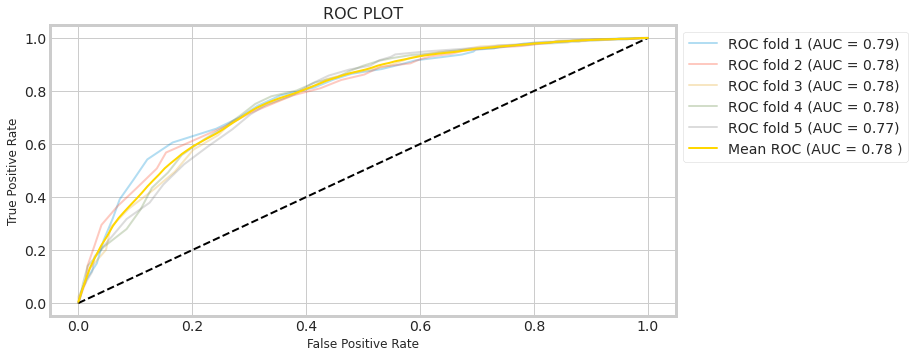

In [64]:
from sklearn.ensemble import RandomForestClassifier
model_rf  = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())
])

#plotting roc curve with 5 number of splits
plot_roc(X, y, estemator=model_rf, n_splits=5)